# Библиотеки




In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from math import *
# from iminuit import Minuit
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.tri as mtri
%pylab inline
import warnings
from scipy import stats
from scipy.integrate import quad
import plotly.express as px
from scipy import stats
from scipy import interpolate
import torch.utils.data as data_utils
warnings.filterwarnings('ignore')
plt.rcParams['font.size']=15

Populating the interactive namespace from numpy and matplotlib


C:\Users\Vasilisa\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trunc', 'isnan', 'fmod', 'isclose', 'degrees', 'hypot', 'exp', 'frexp', 'expm1', 'nan', 'log10', 'isfinite', 'sqrt', 'inf', 'remainder', 'gcd', 'e', 'ceil', 'ldexp', 'log1p', 'radians', 'sin', 'isinf', 'log2', 'pi', 'log', 'tan', 'cos', 'gamma', 'fabs', 'copysign', 'floor', 'sinh', 'cosh', 'tanh', 'modf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Загрузка данных 

In [21]:
direct='D:/Sphere/approximation/appro_sph/mosaic_hits/sphere-2/QGSJET_II/10PeV/900/'
files_p='p/10-20/mh_m01_p_10PeV_10-20_900_01-60'

f_coord='D:/Sphere/approximation/appro_sph/mosaic_hits/sphere-2/mosaic_pmt_coords.txt'
coord=pd.read_csv(f_coord,header=None,sep='\s+',names=['n','x','y','z'])   # Загружаю координаты центров каждого ФЭУ
coord['n']=coord['n']-1         # Начинаю отсчет номеров ФЭУ с нуля, как в файлах mosaic_hits_*
coord=coord.drop(columns='z')   # Убираю координату z

def extract_data(f_path):
    data=pd.read_csv(f_path,header=0,sep='\s+',names=['n','x','y','z','t','cosx','cosy','cosz'])

    data_clean = data.drop(columns=['x','y','z','cosx','cosy','cosz'])    # Удаляю излишне точные координаты
                                                        # входа фотонов и направляющие косинусы, которые 
                                                        # в эксперименте не фиксируются, это результат подробного моделирования.
    # В итоге data_clean состоит из --- ['n','t','x','y']
    return data_clean

# Функция для обработки данных в видеоряд

In [22]:
def video(f_list):
    dt=15  # ns
    stop_cadre=50
    glob_array=[]
    idx=0
    df_n=pd.DataFrame({'n':np.arange(0,121,1)})
    sum_Fe=[]
    for f_path in f_list[:]:
        data=extract_data(f_path)
        data=data.sort_values(['t'])
        cadre=[]
        if (idx+1)%200==0:  print(idx)

        for t in np.arange(data['t'].min(),data['t'].max(),dt): 
            if t < stop_cadre*dt + data['t'].min():
                df_n=pd.DataFrame({'n':np.arange(0,121,1)})    # Список из номеров ФЭУ    ==121==

                d_n_count=data[(data['t']>t)&(data['t']<t+dt)].groupby('n').agg({'n':['count']})['n']   # кол-во активаций и в каких ФЭУ
                df_n_count=pd.DataFrame({'n':d_n_count['count'].index,'c':d_n_count['count'].to_numpy()}) 

                df=df_n.merge(df_n_count,on='n',how='left').drop(columns='n').fillna(0)  # Список из активаций ФЭУ, номера ФЭУ по порядку (по индексу)

                cadre.append(df.to_numpy().reshape(-1))

        if t < stop_cadre*dt + data['t'].min():     # До 75 кадров доходим
            add_to=int(stop_cadre-(t-data['t'].min())/dt-1)   # Тут -1 есть!
            [cadre.append(np.zeros(121))  for i in range(add_to)]   #    ==121==
        cadre=np.array(cadre).reshape(stop_cadre,11,11,1)
        idx+=1

                  
        glob_array.append(cadre)
    glob_array=np.array(glob_array)         # Возвращает массив [6000,50,11,11,1] , 6000 - число событий, 50 - число кадров, 11х11 - сетка детекторов ФЭУ, из них активируются только 109.
    return glob_array

In [23]:
f_list=list(Path(direct+files_p).glob('mos*'))   # Менять q and type_particle!
glob_array=video(f_list)
np.save((direct+'glob_array_p_q2.npy'),np.array(glob_array).reshape(-1))   # Менять q and type_particle!

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999


# Функция для обработки в две карты, по среднему времени и числу фотонов

In [24]:
def map2D(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11=[]
    df_11t=[]
    df_2map=[]
    idx=0
    for f_path in f_list[:]:
        data=extract_data(f_path)
        if (idx+1)%200==0:  print(idx)

        d_num_count=data.groupby('n').agg({'n':['count']})['n']
        df_num_count=pd.DataFrame({'n':d_num_count['count'].index,'count':d_num_count['count'].to_numpy()})
        df_11=(np.array(df_num.merge(df_num_count,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1)).tolist()

        data['t']=(data['t']-min(data['t']))/(data['t'].max()-data['t'].min())  # Нормализую данные по времени, ибо каждое событие должно начинаться с 0!
        d_t_mean=data.groupby('n').agg({'t':['mean']})
        df_t_mean=pd.DataFrame({'n':d_t_mean['t'].index,'mean':d_t_mean['t']['mean'].to_numpy()})
        df_11t=(np.array(df_num.merge(df_t_mean,on='n',how='left').drop(columns='n').fillna(0)).reshape(-1)).tolist()
        df_2map.append([df_11,df_11t])
        idx+=1

    return df_2map

In [25]:
f_list=list(Path(direct+files_p).glob('mos*'))  

df_2map=np.array(map2D(f_list))
df_2map=df_2map.reshape(df_2map.shape[0],2,11,11)
df_2map.shape

np.save(Path.cwd()/(direct+'map2_p_q2.npy'),df_2map.reshape(-1))           

199
399
599
799
999
1199
1399
1599
1799
1999
2199
2399
2599
2799
2999
3199
3399
3599
3799
3999
4199
4399
4599
4799
4999
5199
5399
5599
5799
5999


## Иллюстрация кол-ва фотонов 

## 2D вид сверху

(6000, 2, 121)


Text(0, 0.5, 'y, мм')

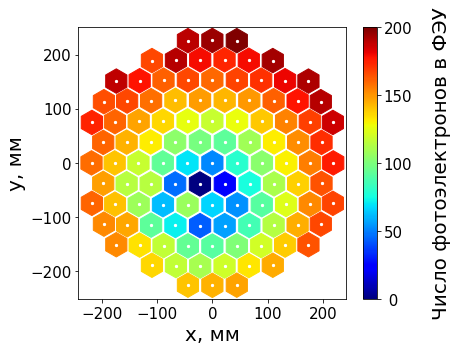

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

df = extract_map_data(direct+'map2_N.npy')
x,y,I=df['x'],df['y'],df['I']   
    
fig=plt.figure(figsize=(6,5))
I=np.log10(I) 

cax=plt.scatter(x,y,c=I,cmap='jet',marker='h',s=600)
plt.scatter(x,y,c='white',marker='o',s=5)

lg_tick=np.linspace(I.min(),I.max(),5, endpoint=True)
# v1 = np.linspace(10**(I).min(), 10**(I).max(), 5, endpoint=True)
v1 = np.linspace(10**(I).min(), 200, 5, endpoint=True)

cbar=plt.colorbar(cax,ticks=lg_tick) #ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["{:2.0f}".format(i) for i in v1])
cbar.ax.set_ylabel('Число фотоэлектронов в ФЭУ',fontsize=20)
cbar.ax.get_yaxis().labelpad = 20

plt.xlabel('x, мм',fontsize=20)
plt.ylabel('y, мм',fontsize=20)
# plt.savefig('drive/MyDrive/mosaic_hits/fpr_size_log_dot.png',bbox_inches='tight')

## 2D картина времени

(6000, 2, 121)


Text(0, 0.5, 'y, мм')

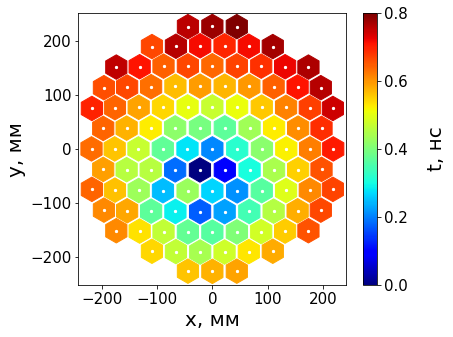

In [17]:
df = extract_map_data(direct+'map2_N.npy')
x,y,I=df['x'],df['y'],df['I']   
    
fig=plt.figure(figsize=(6,5))
I=np.log10(I)  #!!! LOG 10 !!!

cax=plt.scatter(x,y,c=I,cmap='jet',marker='h',s=600)
plt.scatter(x,y,c='white',marker='o',s=5)

lg_tick=np.linspace(I.min(),I.max(),5, endpoint=True)
# v1 = np.linspace(10**(I).min(), 10**(I).max(), 5, endpoint=True)
v1 = np.linspace(0,10**(I).max()-10**(I).min(), 5, endpoint=True)

cbar=plt.colorbar(cax,ticks=lg_tick) #ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["{:2.1f}".format(i) for i in v1])
cbar.ax.set_ylabel('t, нс',fontsize=20)
cbar.ax.get_yaxis().labelpad = 20

plt.xlabel('x, мм',fontsize=20)
plt.ylabel('y, мм',fontsize=20)
# plt.savefig('drive/MyDrive/mosaic_hits/time_log_dot.png',bbox_inches='tight')

# Проверка загруженных файлов

In [ ]:
p=np.load( direct+'work/glob_array.npy')   
p=p.reshape(6000,50,11,11,1)
p

array([46., 23., 18., ...,  0.,  0.,  0.])

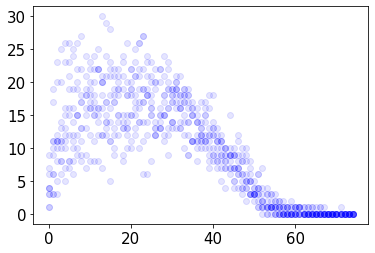

In [ ]:
fig=plt.figure()
stop_cadre=50
for j in range(10):
    for i in range(stop_cadre):
        plt.scatter(i,np.count_nonzero(p[j,i,:,:]),color='blue',alpha=0.1)
# plt.savefig('nonzero_cadre.png')

По такой форме ясно, что файлы загружены верно

# График активации ФЭУ от времени

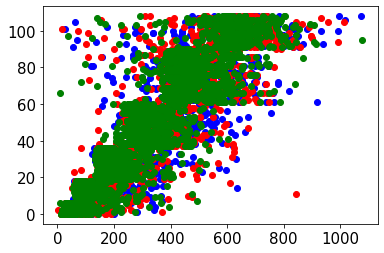

In [ ]:
def main(f_list):
    df_num=pd.DataFrame({'n':np.arange(0,121,1)})
    df_11=[]
    for f_path in f_list[:20]:
        data=extract_data(f_path)
        min_t=data['t'].min()
        data['t']-=min_t
        d_num_count=data.groupby('n').agg({'t':['mean']})
        
        plt.scatter(d_num_count['t']['mean'], d_num_count['t'].index, color=col, label=lab)

    
# График активации ФЭУ от времени
fig=plt.figure()
col=['blue']
lab='p'
f_list=list(Path(direct+files_p).glob('mos*'))
main(f_list)

col=['red']
lab='N'
f_list=list(Path(direct+files_N).glob('mos*'))
main(f_list)

col=['green']
lab='Fe'
f_list=list(Path(direct+files_Fe).glob('mos*'))
main(f_list)

# plt.legend()

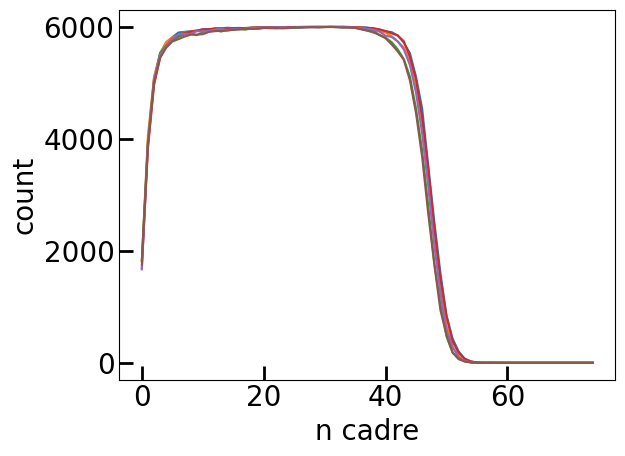

In [ ]:
fig=plt.figure()
for i in range(6):
    hist=hist_activ(data_all[i])
    plt.plot(hist['h'])
# count more 5 activation in cadre
plt.ylabel('count')
plt.xlabel('n cadre')
plt.savefig('drive/MyDrive/mosaic_hits/hist_activ.png',bbox_inches='tight')

Вывод: можно всего оставлять 50 кадров. Потому что все остальные практически не содержат активаций ФЭУ. 